In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tfa-nightly
!pip install import-ipynb
import import_ipynb
import tensorflow as tf
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tqdm import tqdm
from fastprogress import master_bar, progress_bar
%cd '/content/drive/MyDrive/MS loss'

     |████████████████████████████████| 1.1MB 5.3MB/s 
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=117e364c0581128e647e7d468746453bcd6b6ecdfc62bc323fe0c386926a47d2
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/MyDrive/MS loss


In [ ]:
%run UnetModel.ipynb
# %run MumfordLoss.ipynb
%run augment_data.ipynb


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
swish (Swish)                   (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-10):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=1e-10):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

In [ ]:
x = np.asarray(np.load('./dataACDCA/x_crop_128.npy'),np.float32)
y = np.load('./dataACDCA/y_crop_128.npy')

In [ ]:
np.random.seed(123)
len_dev = x.shape[0]//5
len_train = x.shape[0] - len_dev
rand_index = np.random.permutation(x.shape[0])
x_test = x[rand_index[:len_dev]]
y_test = y[rand_index[:len_dev]]
x_train = x[rand_index[len_dev:]]
y_train = y[rand_index[len_dev:]]

In [ ]:
# plt.figure(1)
# label_endo = tf.where(y_test == 2.0, 1.0, 0.0)
# label_epi =  tf.where(y_test == 1.0, 1.0, 0.0) + label_endo
# plt.subplot(131),plt.imshow(x[102][...,0],cmap='gray')
# plt.subplot(132),plt.imshow(label_epi[102][...,0],cmap='gray')
# plt.subplot(133),plt.imshow(y_test[102][...,0],cmap='gray')

In [ ]:
BATCH_SIZE = 32
buffer_size = x_train.shape[0]

@tf.function
def gen_image(image,mask):
  # image, mask = brightness(image,mask)
  #image, mask = saturation(image,mask)
  image, mask = flip(image,mask)
  image, mask = rotate_image(image,mask)
  image, mask = normalize(image, mask)
  return image, mask
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size).map(gen_image).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).map(normalize).batch(BATCH_SIZE*2)

In [ ]:
class MSLoss_vs2():
  def levelsetLoss(self,target, output):
    loss = 0.0
    for ich in range(target.shape[3]):
        target_ = target[...,ich:ich+1]    
        pcentroid = tf.reduce_sum(target_ * output, (1,2),keepdims=True)/tf.reduce_sum(output, (1,2),keepdims = True)   
        plevel = target_ - pcentroid
        pLoss = plevel * plevel * output
        loss += tf.reduce_sum(pLoss)
    return loss
      
  def activeContourLoss(self,y_true,y_pred,outDim =3,smooth=0.001):     
    yTrueOnehot = tf.one_hot(tf.squeeze(tf.cast(y_true,tf.uint8),axis=-1), depth = outDim)
    loss =  y_pred * (1-yTrueOnehot) + (1-y_pred)*yTrueOnehot
    return tf.reduce_mean(loss)
    #this is Luac:
    # loss =  - tf.cast(tf.math.log(1-y_pred+smooth),tf.float32) * (1-yTrueOnehot ) - tf.cast(tf.math.log(y_pred+smooth),tf.float32)*yTrueOnehot
    # return tf.reduce_mean(loss)
                    
  def gradientLoss(self,input,penalty = "l1"):

    dH = tf.math.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = tf.math.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    if penalty == "l2":
        dH = dH * dH
        dW = dW * dW

    loss =  tf.reduce_sum(dH) +  tf.reduce_sum(dW)
    return loss

In [ ]:
class Mumford_Unet_vs2(MSLoss_vs2):
  def __init__(self,model):
    super().__init__()
    self.model = model
    self.optimizer = None
    self.trainData = None
    self.testData = None
    self.batch_size = BATCH_SIZE
    self.train_step = x_train.shape[0] // self.batch_size +1
    self.learning_rate = 0.001

  def optimizer_fc(self,op_type = "adam", op_param = 0.005):
    if op_type == 'adam':
      self.optimizer =  tf.keras.optimizers.Adam(op_param)
    elif op_type == "nadam":
      self.optimizer =  tf.keras.optimizers.Nadam(op_param)

  def loss(self, image, output, trueLabel, alpha = 1e-3, beta = 0.001):
    # print('\rgradient loss: ', self.gradientLoss(output),' leverset loss: ', self.levelsetLoss(image,output),' active loss: ',self.activeContourLoss(trueLabel, output), end="")
    return alpha * ( self.levelsetLoss(image,output) + beta * self.gradientLoss(output))/self.batch_size + self.activeContourLoss(trueLabel, output)
    # return self.activeContourLoss(trueLabel, output)



  def metrics(self,y_true,y_pred):
    output_standard = tf.expand_dims(tf.argmax(y_pred,axis=-1),axis = -1)
    output_endo = tf.where(output_standard == 2, 1.0, 0.0)
    output_epi =  tf.where(output_standard == 1, 1.0, 0.0) + output_endo
    label_endo = tf.where(y_true == 2, 1.0, 0.0)
    label_epi =  tf.where(y_true == 1, 1.0, 0.0) + label_endo

    dice_coef_endo = dice_coef(label_endo, output_endo)
    dice_coef_epi = dice_coef(label_epi, output_epi)
    jaccards_coef_endo = jaccard_coef(label_endo, output_endo)
    jaccards_coef_epi = jaccard_coef(label_epi, output_epi)
    return dice_coef_endo, dice_coef_epi, jaccards_coef_endo, jaccards_coef_epi

  def evaluateTest(self,testDataset):
    test_dices_endo =  []
    test_dices_epi = []
    test_jaccards_endo =  []
    test_jaccards_epi = []
    for xBatchTest, yBatchTest in testDataset:
      yPredBatchTest = self.model(xBatchTest, training =False)
      diceEndoTest, diceEpiTest, jaccardEndoTest, jaccardEpiTest =  self.metrics(yBatchTest, yPredBatchTest)

      test_dices_endo.append(diceEndoTest)
      test_dices_epi.append(diceEpiTest)
      test_jaccards_endo.append(jaccardEndoTest)
      test_jaccards_epi.append(jaccardEpiTest)
    return np.mean(test_dices_endo), np.mean(test_dices_epi), np.mean(test_jaccards_endo), np.mean(test_jaccards_epi)
  def epoch_training(self,model,optimizer, trainDataset, testDataset, mb, stepTrain, alpha_loss, beta_loss):
    train_losses = []
    train_dices_endo =  []
    train_dices_epi = []
    train_jaccards_endo =  []
    train_jaccards_epi = []

    trainDataset = iter(trainDataset)  
    for _ in progress_bar(range(stepTrain),parent = mb):   
      with tf.GradientTape() as tape:
        image, y_true = next(trainDataset)
        y_pred = self.model(image, training = True)
        total_loss  =  self.loss(image, y_pred, y_true, alpha_loss, beta_loss)

      
      grad  = tape.gradient(total_loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(grad,self.model.trainable_variables))

      diceEndoTrain, diceEpiTrain, jaccardEndoTrain, jaccardEpiTrain =  self.metrics(y_true, y_pred)

      mb.child.comment = 'Train loss {:.4f}'.format(total_loss)

      train_losses.append(total_loss)
      train_dices_endo.append(diceEndoTrain)
      train_dices_epi.append(diceEpiTrain)
      train_jaccards_endo.append(jaccardEndoTrain)
      train_jaccards_epi.append(jaccardEpiTrain)

    trainLossMean = np.mean(train_losses)
    trainDiceEndoMean = np.mean(train_dices_endo)
    trainJaccardEndoMean = np.mean(train_jaccards_endo)
    trainDiceEpiMean = np.mean(train_dices_epi)
    trainJaccardEpiMean = np.mean(train_jaccards_epi)

    testDiceEndoMean, testDiceEpiMean, _, _ = self.evaluateTest(testDataset)

    return trainLossMean, trainDiceEndoMean, trainDiceEpiMean, testDiceEndoMean, testDiceEpiMean


  def train(self,num_epoch, reduceLrEpoch=15 , earlyStoping=31, minLr=1e-5, alpha_loss= 1e-6, beta_loss = 1,checkpoint_prefix = "./weightAlpha(1e-6)/ckpt_{score:.4f}.h5"):
    mb = master_bar(range(num_epoch))
    epochs_list = []
    history = dict()
    training_losses = []
    trainDiceEndo_list = []
    trainDiceEpi_list = []
    testDiceEndo_list = []
    testDiceEpi_list = []
    learningRate_list = []
    best_score  = 0
    count = 0
    for epoch in mb:
      count += 1
      epochs_list.append(epoch+1)

      trainLoss, trainDiceEndo, trainDiceEpi, testDiceEndo, testDiceEpi  \
      = self.epoch_training(self.model, self.optimizer, self.trainData, self.testData, mb, self.train_step, alpha_loss, beta_loss)

      mb.write('Finish train epoch {} with loss {:.4f} trainDiceEndo: {:.2f}, trainDiceEpi: {:.2f}, testDiceEndo: {:.2f},testDiceEpi: {:.2f}'.format(epoch+1, trainLoss, trainDiceEndo, trainDiceEpi, testDiceEndo, testDiceEpi ))

      training_losses.append(trainLoss)
      trainDiceEndo_list.append(trainDiceEndo)
      trainDiceEpi_list.append(trainDiceEpi)
      testDiceEndo_list.append(testDiceEndo)
      testDiceEpi_list.append(testDiceEpi)
      learningRate_list.append(self.learning_rate)

      if count % reduceLrEpoch ==0 :
        self.learning_rate = self.learning_rate * 0.5
        if self.learning_rate < minLr:
          self.learning_rate = minLr
        print('learning rate is set to : ',self.learning_rate)
        self.optimizer.learning_rate.assign(self.learning_rate )
    
      mb.update_graph([[epochs_list, training_losses]], [0,num_epoch], [0,0.1])
      if count == earlyStoping :
        break
      ### Check point here ###
      ### Check point follow testDiceEpi ###
      if best_score < testDiceEpi:
          count = 0
          mb.write(">>> Improved Dice-score EPI from {:.4f} to {:.4f}".format(best_score, testDiceEpi))
          best_score = testDiceEpi
          self.model.save_weights(checkpoint_prefix.format(score=best_score))
    history['epoch'] = epochs_list
    history['train_loss'] = training_losses
    history['train_dice_endo'] = trainDiceEndo_list
    history['train_dice_epi'] = trainDiceEpi_list
    history['test_dice_endo'] = testDiceEndo_list
    history['test_dice_epi'] = testDiceEpi_list
    # history['lr'] = learningRate_list
    return history 

In [ ]:
S = seg_net()
nhat = Mumford_Unet_vs2(S)
nhat.learning_rate = 0.001
nhat.trainData = train_dataset
nhat.testData = test_dataset
nhat.optimizer_fc(op_type = "nadam", op_param=nhat.learning_rate)

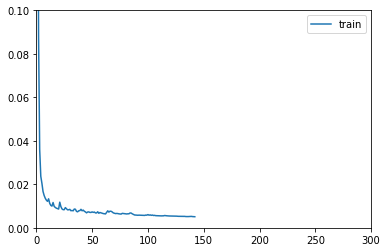

learning rate is set to :  0.0005
learning rate is set to :  0.00025
learning rate is set to :  0.000125


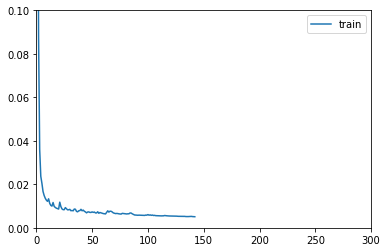

In [ ]:
history = nhat.train(300,checkpoint_prefix="./weightAlpha(1e-6)/ckpt_{score:.4f}.h5")

In [ ]:
# sio.savemat('./weightAlpha(1e-6)/history_LoriginAlpha(1e-6).mat',history)

In [ ]:
nhat.model.load_weights('/content/drive/MyDrive/MS loss/weightAlpha(0)_uac/ckpt_0.9254.h5')

In [ ]:
nhat.evaluateTest(test_dataset)

(0.92544603, 0.9281983, 0.885705, 0.8989112)

In [ ]:
for i in range(x_test.shape[0]):
  y_pred = nhat.model(normalize(x_test[i:i+1],y_test[i:i+1]))
  y_predShow = np.argmax(y_pred,axis = -1)
  plt.figure(i+1)
  plt.subplot(131),plt.imshow(x_test[i,...,0],cmap='gray'),plt.title('image')
  plt.subplot(132),plt.imshow(y_predShow[0],cmap ='gray'),plt.title('predict')
  plt.subplot(133),plt.imshow(y_test[i,...,0],cmap='gray'),plt.title('groundtruth')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
hist = sio.loadmat('/content/drive/MyDrive/MS loss/weightAlpha(1e-6)_uac/history_LuacAlpha(1e-6).mat')

In [ ]:
hist['train_loss'][0]

array([0.22333853, 0.07662826, 0.04083416, 0.02970164, 0.02350345,
       0.02033389, 0.01591443, 0.01471676, 0.01408367, 0.0135718 ,
       0.01199813, 0.01109523, 0.01264529, 0.01125071, 0.01002055,
       0.00988795, 0.0097382 , 0.00924499, 0.00899095, 0.00936419,
       0.00885799, 0.00869597, 0.01101004, 0.00889517, 0.00853252,
       0.00914103, 0.00838611, 0.00840064, 0.00776776, 0.00777959,
       0.00789468, 0.007944  , 0.00774474, 0.00805073, 0.00792514,
       0.00770222, 0.00728081, 0.00743608, 0.00710296, 0.00836341,
       0.0077332 , 0.00730935, 0.00774242, 0.0073465 , 0.0071768 ,
       0.00850066, 0.00764257, 0.00725106, 0.00673049, 0.00662656,
       0.00657555, 0.00658536, 0.0066442 , 0.00651941, 0.00684302,
       0.00657597, 0.00648629, 0.00633075, 0.00689703, 0.00652409,
       0.00622737, 0.00622713, 0.00620171, 0.00621367, 0.00610627,
       0.00624056, 0.00617595, 0.0063142 , 0.00655824, 0.00614684,
       0.00604089, 0.00596834, 0.00585742, 0.005848  , 0.00586

In [ ]:
hist.keys()

dict_keys(['__header__', '__version__', '__globals__', 'epoch', 'train_loss', 'train_dice_endo', 'train_dice_epi', 'test_dice_endo', 'test_dice_epi'])

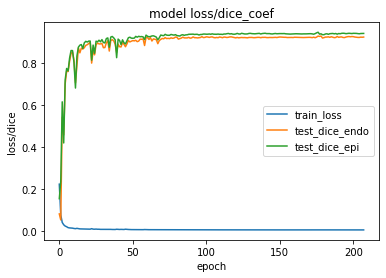

In [ ]:
plt.plot(hist['train_loss'][0])
# plt.plot(hist['val_loss'])
# plt.plot(hist['train_dice_endo'][0])
# plt.plot(hist['train_dice_epi'][0])
plt.plot(hist['test_dice_endo'][0])
plt.plot(hist['test_dice_epi'][0])
plt.title('model loss/dice_coef')
plt.ylabel('loss/dice')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_dice_endo','test_dice_epi'])
plt.savefig('test.png')
plt.show()